In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmodules import *
import identify_shocks_test

%matplotlib inline

In [5]:
dir = './compare_comp_time/'
simulation_list = [directory for directory in os.listdir(dir) if 'Au6_lvl5_' in directory]

In [6]:
simulation_list

['Au6_lvl5_ec9e_basesim', 'Au6_lvl5_ec9e_k12_fiducial']

In [8]:
# Load simulation data
ii=1
s = gadget_readsnap(127,dir+simulation_list[ii]+'/output/', hdf5=True, onlyHeader=True)

# Load shock evolution data
data = np.loadtxt(dir+simulation_list[ii]+'/output/clusterevolution.txt')

# Extract data
time = data[:,0]
init_mass = data[:,1]
mass_evo = data[:,2]
rh_evo = data[:,3]
mlost_sh = data[:,4]
mlost_ev = data[:,5]
tensor_eigenvalues = data[:,6:9]
full_tensor = data[:,9:15]
integrating_flag = data[:,15:21]
tidal_heating = data[:,21]

# Convert tensor data to Gyr^-2
gyr = 3.15576e16 # in s
unit_time = s.parameters['UnitLength_in_cm']/s.parameters['UnitVelocity_in_cm_per_s']
h = s.parameters['HubbleParam']
convert_factor = h**2/time**3 * (gyr/unit_time)**2 # to Gyr^-2
mass_factor = 1e10/h # to Msun
length_factor = s.parameters['UnitLength_in_cm']/3.085e18/h # to pc

# Convert time column to Gyr
time_gyr = s.cosmology_get_lookback_time_from_a(1e-5, is_flat=True) - s.cosmology_get_lookback_time_from_a(time, is_flat=True)
# time_gyr = time*unit_time/gyr

tensor_eigenvalues *= convert_factor[:, np.newaxis]
full_tensor *= convert_factor[:, np.newaxis]
tidal_heating *= gyr**2
init_mass *= mass_factor
mass_evo *= mass_factor
rh_evo *= length_factor
mlost_sh *= mass_factor
mlost_ev *= mass_factor
integrating_flag_cumulative = np.any((integrating_flag>0.), axis=1)

In [17]:
unique, counts = np.unique(init_mass, return_counts=True)
idx = np.argsort(counts)

mass_cl = unique[idx[-20]]
mask = init_mass == mass_cl
time_unique = time[mask]
time_gyr_unique = time_gyr[mask]

shocks = identify_shocks_test.shock_integration(time_gyr_unique[np.argsort(time_gyr_unique)],
                                                mass_evo[mask][np.argsort(time_gyr_unique)],
                                                rh_evo[mask][np.argsort(time_gyr_unique)],
                                                full_tensor[mask,0][np.argsort(time_gyr_unique)])

Cummulative tidal heating 1.434e+01 Gyr^-2
Number of shocks: 184


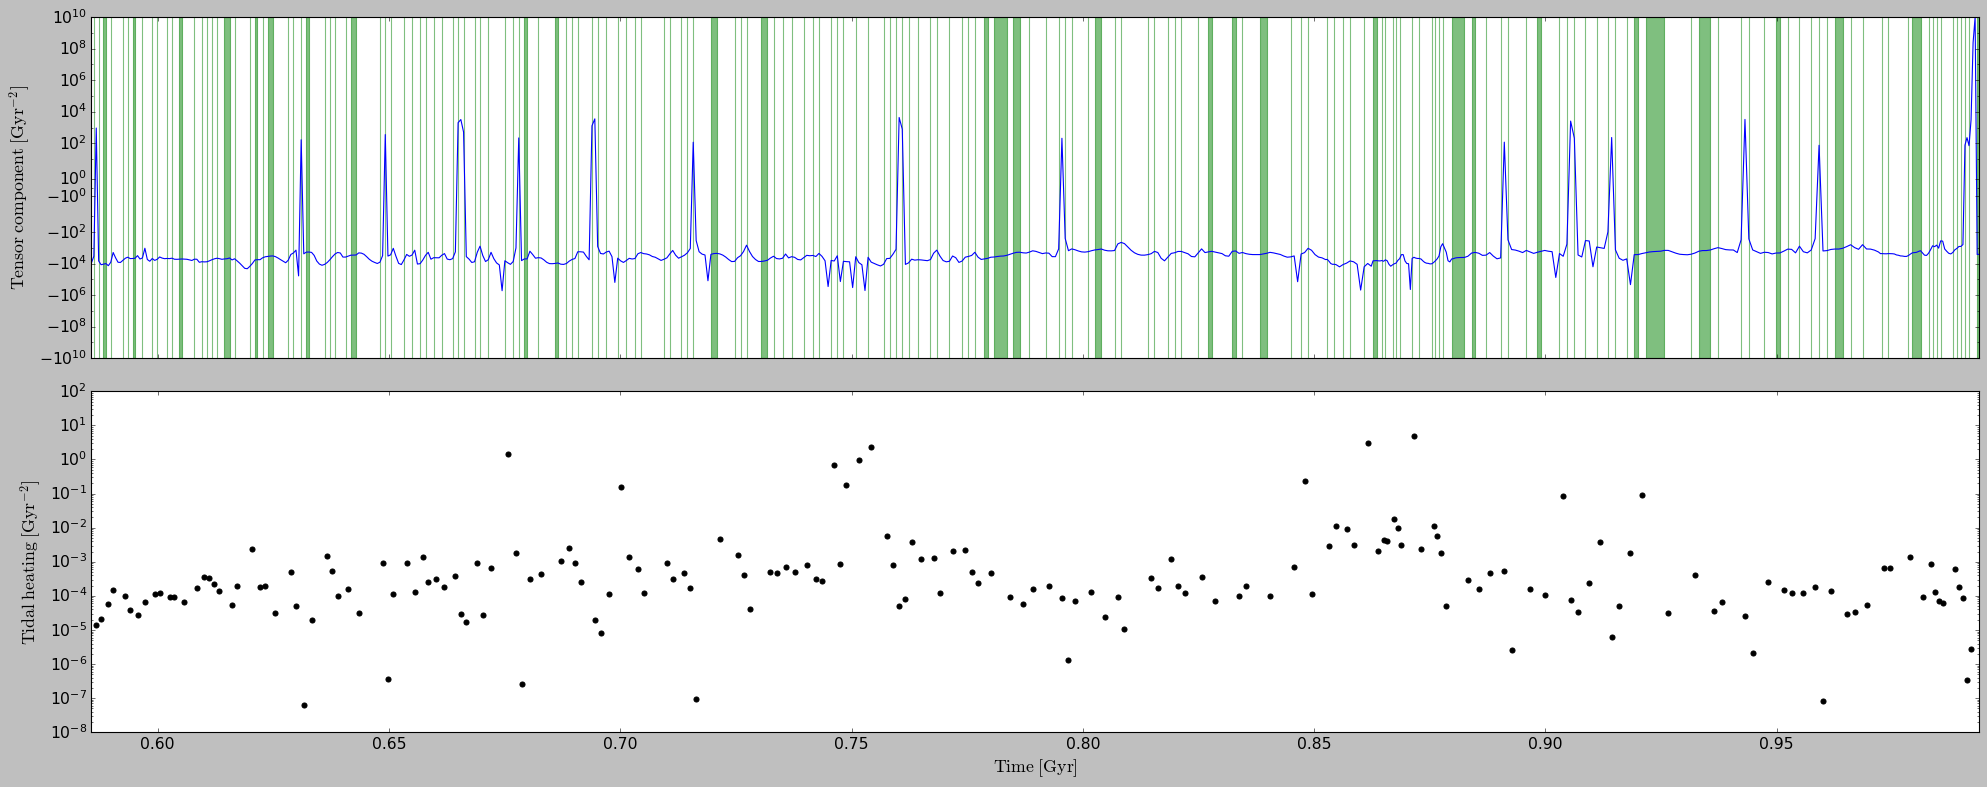

In [18]:
shocks.get_shock_events_method_1()

tidal_heating_events_1 = np.array(shocks.tidal_heating_events)
tidal_heating_events_1 = tidal_heating_events_1[tidal_heating_events_1[:,1]>0]
fig, ax = plt.subplots(2, 1, figsize=(25, 10), sharex=True)

ax[0].plot(shocks.time, shocks.component)
ax[0].fill_between(shocks.time, -1e10, 1e10, where=shocks.integrating_flag, alpha=0.5, color='green')
ax[0].set_yscale('symlog')
ax[0].set_ylim(-1e10, 1e10)
ax[0].set_ylabel(r'$\rm{Tensor}\; \rm{component}\; [\rm{Gyr}^{-2}]$', fontsize=16)
y_ticks = ax[0].get_yticks()
ax[0].set_yticks(y_ticks[::2])
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].scatter(tidal_heating_events_1[:,0], tidal_heating_events_1[:,1], c='k')
ax[1].set_yscale('log')
ax[1].set_xlim(shocks.time[0], shocks.time[-1])
ax[1].set_xlabel(r'$\rm{Time}\; [\rm{Gyr}]$', fontsize=16)
ax[1].set_ylabel(r'$\rm{Tidal}\; \rm{heating}\; [\rm{Gyr}^{-2}]$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

print('Cummulative tidal heating {:.3e} Gyr^-2'.format(shocks.tidal_heating_cumulative))
print('Number of shocks:', shocks.shock_events)
shocks.restart_all_shocks()

Cummulative tidal heating 1.891e+08 Gyr^-2
Number of shocks: 112


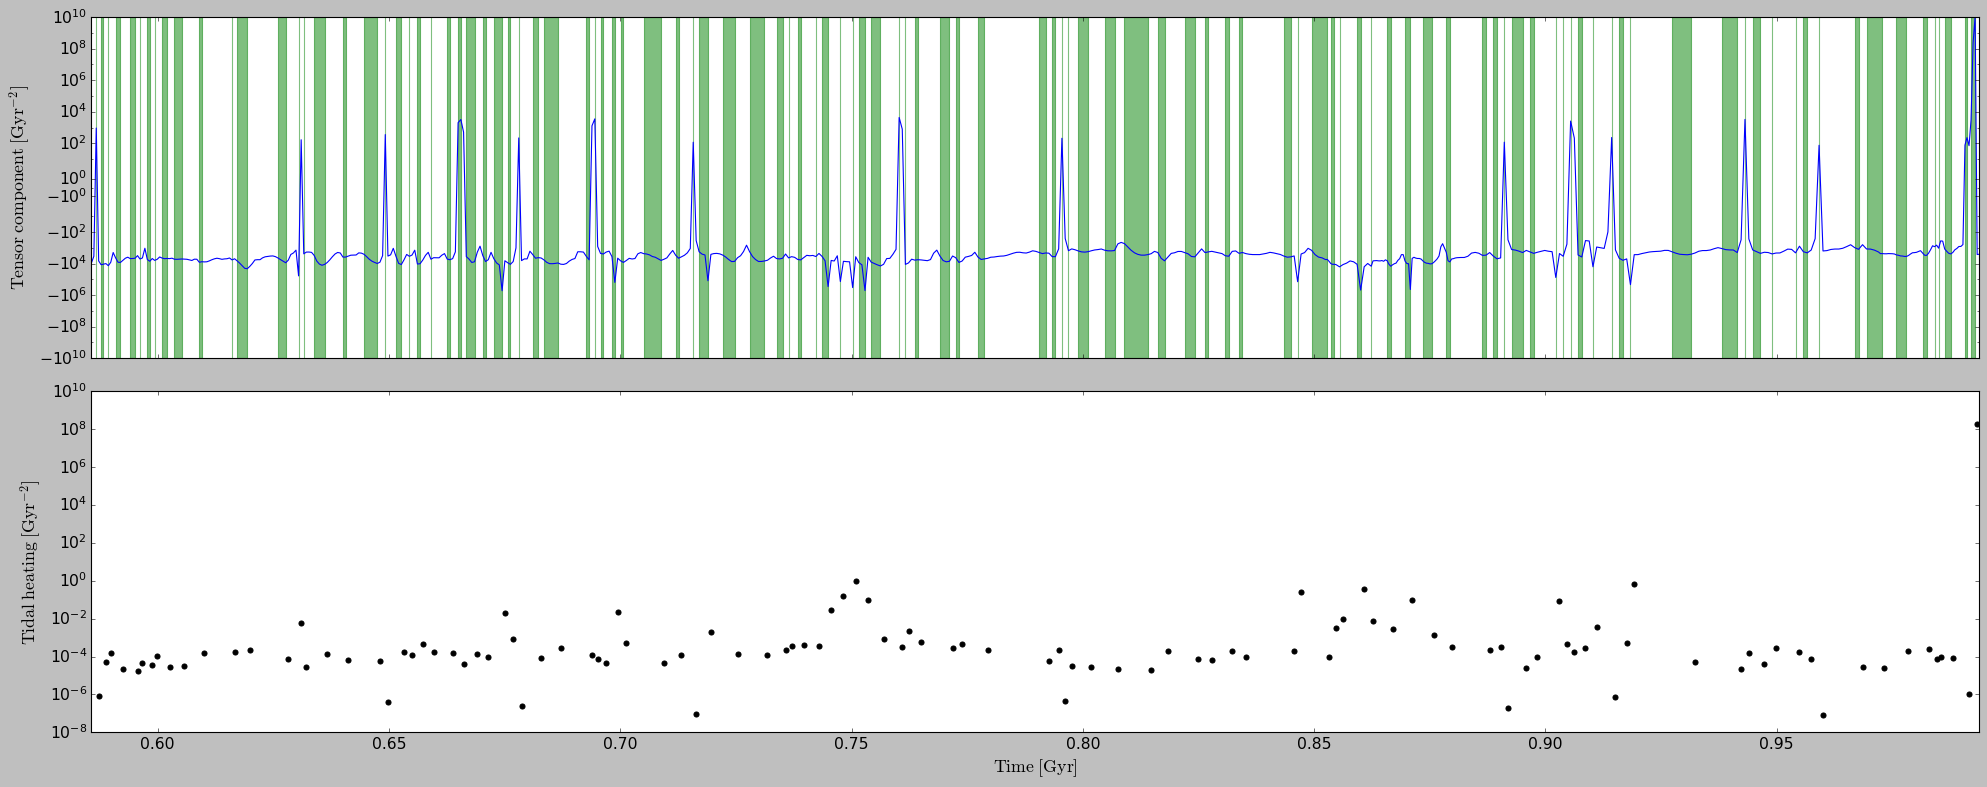

In [19]:
shocks.get_shock_events_method_2()

tidal_heating_events_2 = np.array(shocks.tidal_heating_events)
tidal_heating_events_2 = tidal_heating_events_2[tidal_heating_events_2[:,1]>0]
fig, ax = plt.subplots(2, 1, figsize=(25, 10), sharex=True)

ax[0].plot(shocks.time, shocks.component)
ax[0].fill_between(shocks.time, -1e10, 1e10, where=shocks.integrating_flag, alpha=0.5, color='green')
ax[0].set_yscale('symlog')
ax[0].set_ylim(-1e10, 1e10)
ax[0].set_ylabel(r'$\rm{Tensor}\; \rm{component}\; [\rm{Gyr}^{-2}]$', fontsize=16)
y_ticks = ax[0].get_yticks()
ax[0].set_yticks(y_ticks[::2])
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].scatter(tidal_heating_events_2[:,0], tidal_heating_events_2[:,1], c='k')
ax[1].set_yscale('log')
ax[1].set_xlim(shocks.time[0], shocks.time[-1])
ax[1].set_xlabel(r'$\rm{Time}\; [\rm{Gyr}]$', fontsize=16)
ax[1].set_ylabel(r'$\rm{Tidal}\; \rm{heating}\; [\rm{Gyr}^{-2}]$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

print('Cummulative tidal heating {:.3e} Gyr^-2'.format(shocks.tidal_heating_cumulative))
print('Number of shocks:', shocks.shock_events)
shocks.restart_all_shocks()

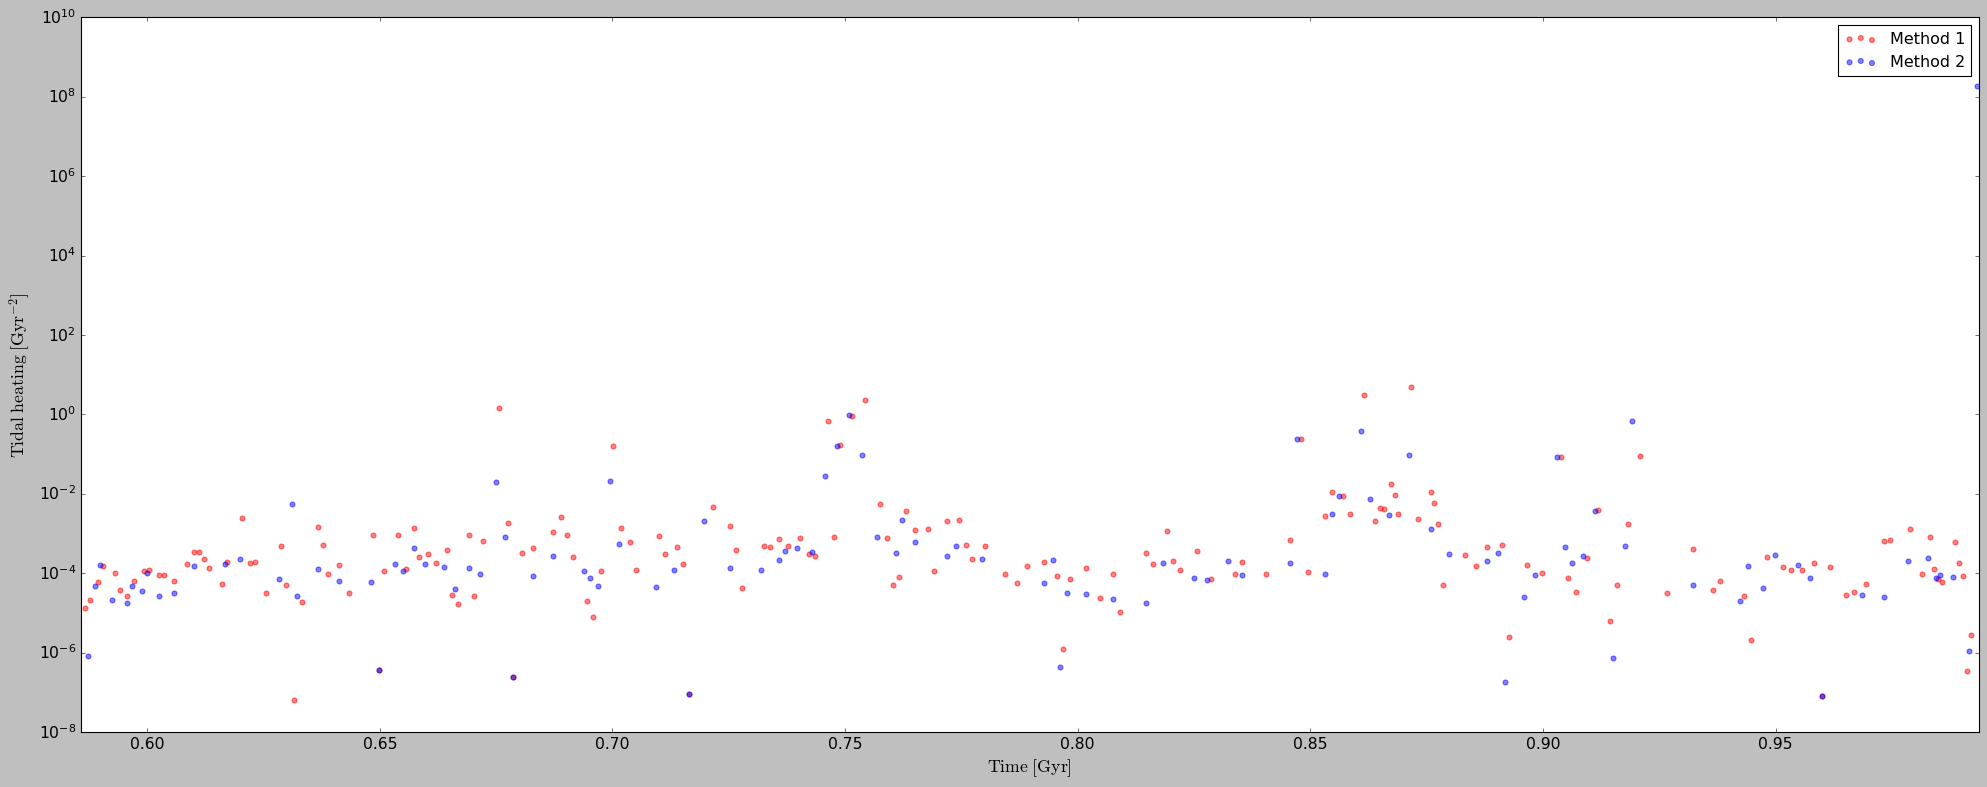

In [21]:
plt.figure(figsize=(25, 10))
plt.scatter(tidal_heating_events_1[:,0], tidal_heating_events_1[:,1], c='r', alpha=0.5, edgecolors='face', label='Method 1')
plt.scatter(tidal_heating_events_2[:,0], tidal_heating_events_2[:,1], c='b', alpha=0.5, edgecolors='face', label='Method 2')
plt.xlim(shocks.time[0], shocks.time[-1])
plt.xlabel(r'$\rm{Time}\; [\rm{Gyr}]$', fontsize=16)
plt.ylabel(r'$\rm{Tidal}\; \rm{heating}\; [\rm{Gyr}^{-2}]$', fontsize=16)
plt.yscale('log')
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()